# CEO-Request Challenge

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻

### 2.1 Data Preparation

In [2]:
from olist.order import Order
from olist.seller import Seller
from olist.data import Olist

In [3]:
olist = Olist()
data = olist.get_data()
orders = Order().get_training_data(with_distance_seller_customer=True)
sellers = Seller().get_training_data()


/Users/victorvoneisenhart-rothe/code/Victorvone/data-context-and-setup/olist/order.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distances['distance_seller_customer'] = distances\
/Users/victorvoneisenhart-rothe/code/Victorvone/data-context-and-setup/olist/order.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distances['distance_seller_customer'] = distances\


In [4]:
# Revenue:
sellers['revenue'] = sellers['sales']*0.1+ sellers['months_on_olist']*80
revenue = sellers[['seller_id', 'revenue']]

In [5]:
#Costs of reviews:
#Get review scores for each order through orders table
orders_reviews = orders[['order_id','review_score']]
orders_sellers = data['order_items'][['order_id', 'seller_id']].drop_duplicates()
 
# Create columns for each review score
reviews_merge = orders_sellers.merge(orders_reviews, on='order_id')
reviews_merge['dim_is_five_star'] = reviews_merge['review_score'].apply(lambda x : 1 if x == 5 else 0)
reviews_merge['dim_is_four_star'] = reviews_merge['review_score'].apply(lambda x : 1 if x == 4 else 0)
reviews_merge['dim_is_three_star'] = reviews_merge['review_score'].apply(lambda x : 1 if x == 3 else 0)
reviews_merge['dim_is_two_star'] = reviews_merge['review_score'].apply(lambda x : 1 if x == 2 else 0)
reviews_merge['dim_is_one_star'] = reviews_merge['review_score'].apply(lambda x : 1 if x == 1 else 0)

#Count each review score
seller_costs = reviews_merge.groupby('seller_id').agg({'dim_is_five_star': ['sum'],'dim_is_four_star': ['sum'],'dim_is_three_star': ['sum'],'dim_is_two_star': ['sum'],'dim_is_one_star': ['sum']}).reset_index()
seller_costs.columns = seller_costs.columns.droplevel(1)

#Calculate costs
seller_costs['review_costs'] = seller_costs['dim_is_three_star']*40 + seller_costs['dim_is_two_star']*50 + seller_costs['dim_is_one_star']*100

#Clean up results
seller_costs.drop(['dim_is_five_star','dim_is_four_star', 'dim_is_three_star', 'dim_is_two_star', 'dim_is_one_star'], axis=1, inplace = True)

In [6]:
#Profits:
#merge revenue and seller_costs
Profits = revenue.merge(seller_costs, on='seller_id')
Profits['profits'] = Profits['revenue'] - Profits['review_costs']
Profits

,seller_id,revenue,review_costs,profits
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2290.307,140,2150.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800,0,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999,0,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,16.799,100,-83.201
...,...,...,...,...
2956,98dddbc4601dd4443ca174359b237166,15.800,0,15.800
2957,f8201cab383e484733266d1906e2fdfa,1208.900,140,1068.900
2958,74871d19219c7d518d0090283e03c137,455.004,0,455.004
2959,e603cf3fec55f8697c9059638d6c8eb5,349.700,0,349.700


In [7]:
sellers

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,revenue,review_costs,profits,share_of_one_stars,share_of_five_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000000,218.70,341.870,140,201.870,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025000,11703.07,2290.307,140,2150.307,0.050000,0.725000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000000,158.00,15.800,0,15.800,0.000000,1.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000000,79.99,7.999,0,7.999,0.000000,1.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000000,167.99,16.799,100,-83.201,1.000000,0.000000,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,98dddbc4601dd4443ca174359b237166,sarandi,PR,0.000000,8.230822,2018-07-14 03:10:19,2018-07-23 15:34:03,0.0,2,2,1.000000,158.00,15.800,0,15.800,0.000000,1.000000,5.00
2957,f8201cab383e484733266d1906e2fdfa,palhoca,SC,0.000000,13.045797,2017-06-17 15:30:11,2018-08-11 19:55:17,14.0,10,10,1.000000,889.00,1208.900,140,1068.900,0.100000,0.500000,4.10
2958,74871d19219c7d518d0090283e03c137,sao paulo,SP,0.000000,3.606625,2018-04-05 17:09:46,2018-08-21 19:25:15,5.0,6,7,1.166667,550.04,455.004,0,455.004,0.000000,1.000000,5.00
2959,e603cf3fec55f8697c9059638d6c8eb5,pelotas,RS,0.000000,6.657634,2017-02-09 02:43:17,2017-06-16 17:30:16,4.0,8,11,1.375000,297.00,349.700,0,349.700,0.000000,0.500000,4.25


### 2.2 What-if Analysis

In [8]:
#sellers along with the products they sold
def it_costs(dataframe):
    costs = 3157.27*math.sqrt(len(dataframe.index))+978.23*math.sqrt(dataframe['quantity'].sum())
    return costs

#Create a method to calculate global profit
def global_profits(dataframe):
    global_profit = dataframe['profits'].sum() - it_costs(dataframe)
    return global_profit

In [13]:
#Sort sellers by increasing profits
sellers_sorted = sellers.sort_values(by=['profits'])
sellers_sorted.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,revenue,review_costs,profits,share_of_one_stars,share_of_five_stars,review_score
768,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,2033,1.096548,123304.83,13770.483,32620,-18849.517,0.124729,0.514100,3.937093
2354,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1806,1987,1.100221,200472.92,21647.292,37540,-15892.708,0.143809,0.482510,3.827873
944,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,1146,1203,1.049738,37177.52,4677.752,19020,-14342.248,0.113935,0.527607,3.997371
1355,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1706,1775,1.040445,104288.42,11948.842,25070,-13121.158,0.116092,0.584483,4.077586
315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,943,1018,1.079533,17535.69,2553.569,14440,-11886.431,0.118211,0.568690,4.074547


In [14]:
#Remove sellers one by one, starting from the one with the lowest profit.
#For each number of sellers to remove, compute the financial impact on Olist global profits.
sellers_sorted_copy = sellers_sorted
profit = global_profits(sellers_sorted_copy)
previous_profit = profit-1
i = 0
profits_df = pd.DataFrame({"Dropped_sellers":[i],
                         "Profit":[profit.round(2)]})

print(f'Baseline profit: {profit.round(2)}')

while(profit >= previous_profit):
    i += 1
    previous_profit = global_profits(sellers_sorted_copy)
    sellers_sorted_copy = sellers_sorted_copy.drop(sellers_sorted_copy['profits'].idxmin())
    profit = global_profits(sellers_sorted_copy)
    new_row = pd.DataFrame({"Dropped_sellers":[i],
                         "Profit":[profit.round(2)]})
    profits_df = pd.concat([profits_df, new_row])

Baseline profit: 819941.94


In [15]:

print (f'dropping {i-1} sellers from the dataset results in the highest profit margin for Olist, with a profit of {previous_profit.round(2)}')
profits_df

dropping 746 sellers from the dataset results in the highest profit margin for Olist, with a profit of 1159342.24


,Dropped_sellers,Profit
0,0,819941.94
0,1,841800.23
0,2,860660.94
0,3,876824.69
0,4,892638.10
...,...,...
0,743,1159331.72
0,744,1159336.10
0,745,1159340.18
0,746,1159342.24


In [11]:
sellers_sorted_copy = sellers_sorted
profit = global_profits(sellers_sorted_copy)
i = 0
profits_df_for = pd.DataFrame({"Dropped_sellers":[i],
                         "Profit":[profit.round(2)]})

for j in range(1200):
    previous_profit = global_profits(sellers_sorted_copy)
    sellers_sorted_copy = sellers_sorted_copy.drop(sellers_sorted_copy['profits'].idxmin())
    profit = global_profits(sellers_sorted_copy)
    new_row = pd.DataFrame({"Dropped_sellers":[j+1],
                         "Profit":[profit.round(2)]})
    profits_df_for = pd.concat([profits_df_for, new_row])
    
profits_df_for

,Dropped_sellers,Profit
0,0,819941.94
0,1,841800.23
0,2,860660.94
0,3,876824.69
0,4,892638.10
...,...,...
0,1196,1135204.51
0,1197,1135065.03
0,1198,1134929.32
0,1199,1134793.24


Text(0, 0.5, 'Net Profit')

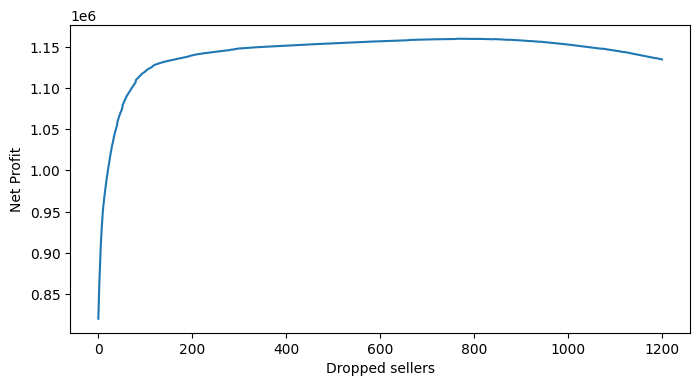

In [12]:
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(profits_df_for['Dropped_sellers'], profits_df_for['Profit'])
ax.set_xlabel('Dropped sellers')
ax.set_ylabel('Net Profit')